# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [131]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

In [132]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [133]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [134]:
sheet1 = df[list(df.keys())[0]] # Extract the first shee
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [135]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [136]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [137]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [138]:
fig = px.box(sheet1, x="Price")
fig.show()

In [139]:
fig = px.box(sheet1, x="Open")
fig.show()

In [140]:
fig = px.box(sheet1, x="High")
fig.show()

In [141]:
fig = px.box(sheet1, x="Low")
fig.show()

In [142]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

In [143]:
sheet1['Vol.'] = sheet1['Vol.'].str[:-1].astype(float)
fig = px.box(sheet1, x='Vol.')
fig.show()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_20230/3553842436.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [144]:
sheet1['Vol.'].describe()

count    311.000000
mean      73.056977
std       38.058095
min        8.760000
25%       47.670000
50%       66.260000
75%       85.120000
max      263.040000
Name: Vol., dtype: float64

In [145]:
fig = px.box(sheet1, x="Change %")
fig.show()

In [146]:
sheet1['Change %'].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

Plot the price over time.

In [147]:
# Convert dates to DateTime
sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S') 

# Set Datetime as the index
sheet1 = sheet1.set_index(pd.DatetimeIndex(sheet1["Datetime"])).sort_index()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_20230/3080680778.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
fig = px.line(sheet1, x='Datetime', y="Price")
fig.show()

### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

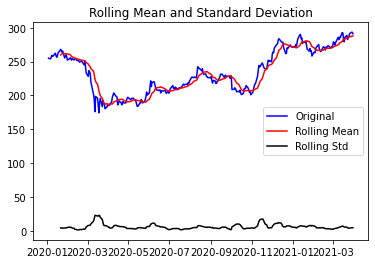

Results of dickey fuller test
Test Statistics                 -0.986360
p-value                          0.758207
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [149]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

<Figure size 432x288 with 0 Axes>

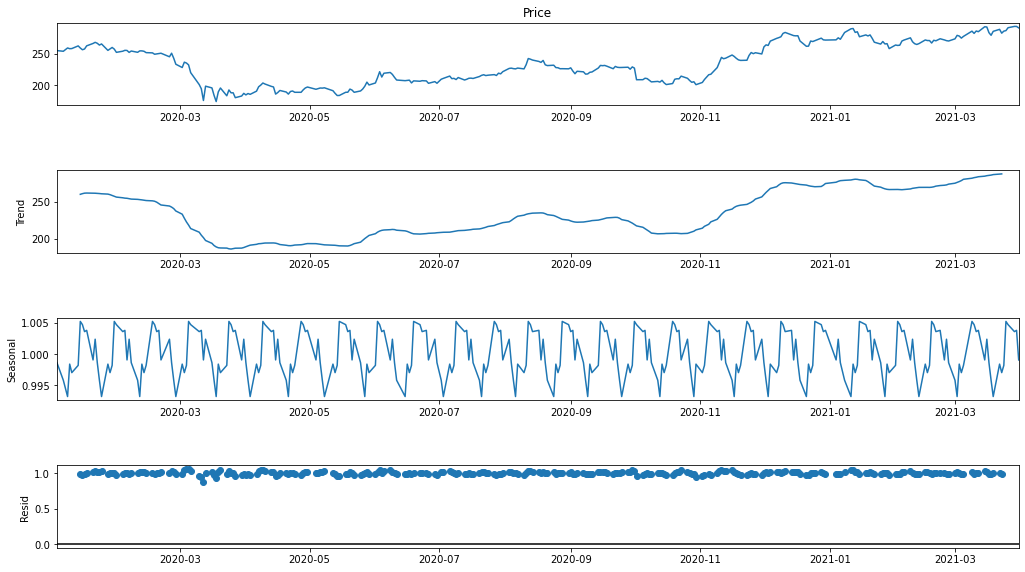

In [150]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(sheet1.Price, period=12, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We can try and normalize the seasonality by the difference of log to price and shifted the log value of price to one step.

<AxesSubplot:title={'center':'after log transformed & differencing'}, xlabel='Datetime'>

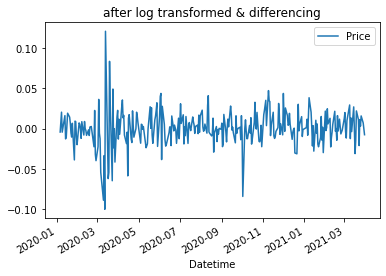

In [151]:
log_prices = pd.DataFrame(sheet1.Price.apply(lambda x : np.log(x)))
log_diff = log_prices - log_prices.shift()
#ax1 = plt.subplot()
log_diff.plot(title='after log transformed & differencing')
#ax2 = plt.subplot()
#sheet1.Price.plot(title='original'); 

Try the test for stationarity again.

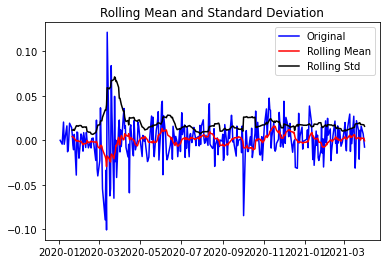

Results of dickey fuller test
Test Statistics               -5.905231e+00
p-value                        2.718502e-07
No. of lags used               7.000000e+00
Number of observations used    3.030000e+02
critical value (1%)           -3.452118e+00
critical value (5%)           -2.871127e+00
critical value (10%)          -2.571878e+00
dtype: float64


In [152]:
test_stationarity(log_diff.fillna(0))

Now the p-value is < 0.05.

Now lets split the data into training and testing data.

In [153]:
train_data = log_diff[log_diff.index < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = log_diff[(log_diff.index >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

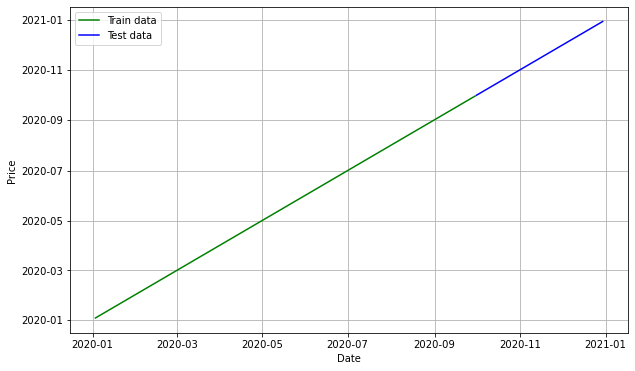

In [154]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data.index, train_data.index, 'green', label='Train data')
plt.plot(test_data.index, test_data.index, 'blue', label='Test data')
plt.legend()

In [155]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

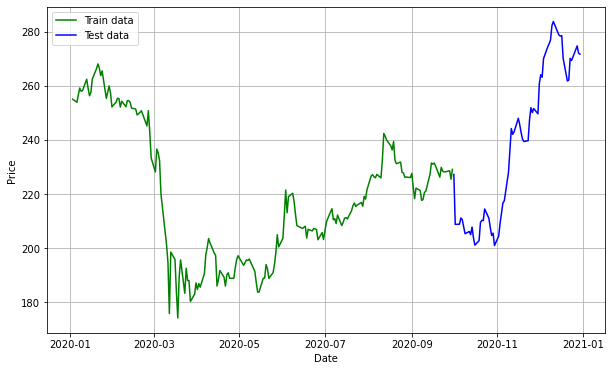

In [156]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data["Datetime"], train_data["Price"], 'green', label='Train data')
plt.plot(test_data["Datetime"], test_data["Price"], 'blue', label='Test data')
plt.legend()

Using Auto ARIMA, we'll now choose the p, d and q values for our model, where:
- `p`: The auto-regressive part
- `d`: The integrated/differencing part - the amount of past time points to subtract from the current value
- `q`: The moving average part

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1492.235, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1490.238, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1490.239, Time=0.05 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1488.346, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1490.352, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.283 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  311
Model:                        SARIMAX   Log Likelihood                 747.117
Date:                Tue, 15 Nov 2022   AIC                          -1492.235
Time:                        20:33:42   BIC                          -1488.495
Sample:                             0   HQIC                         -1490.740
                                - 311                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

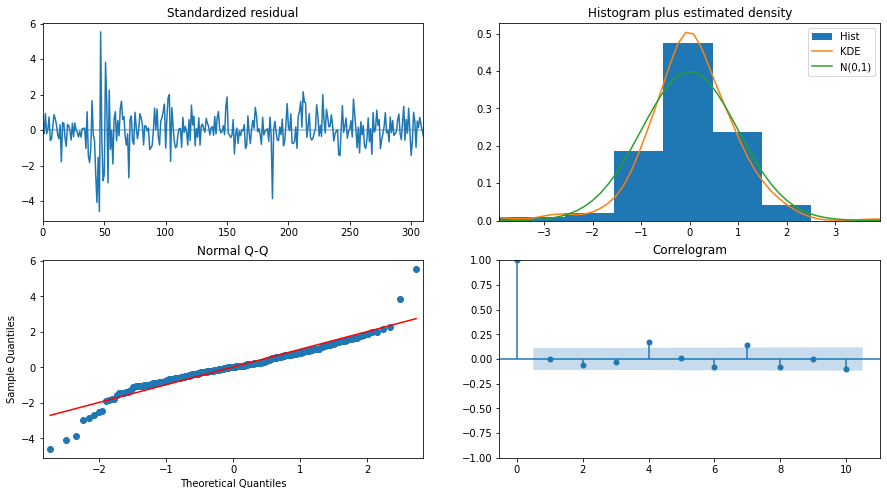

In [157]:
# Use Auto ARIMA to find the best p, d, and q values
model_autoARIMA = auto_arima(log_diff.fillna(0), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality # TODO: Try with seasonal as well
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We get the result, `Best model:  ARIMA(0,1,0)(0,0,0)[0]`, therefore the best parameters are p=0, d=1, q=0.

In [158]:
# Build Model
#model = ARIMA(train_data.resample("D").last().Price, order=model_autoARIMA.order)
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,0])
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  272
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -563.438
Date:                Tue, 15 Nov 2022   AIC                           1128.875
Time:                        20:33:43   BIC                           1132.477
Sample:                    01-03-2020   HQIC                          1130.321
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        20.1404      1.119     17.992      0.000      17.946      22.334
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):               865.39
Prob(Q):                              0.36   Pr

Lets also created models with the following p, d and q values:
- [0,1,1]
- [0,1,2]
- [1,1,1]

In [159]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,1])
fitted2 = model.fit()  
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  272
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -560.065
Date:                Tue, 15 Nov 2022   AIC                           1124.129
Time:                        20:33:43   BIC                           1131.334
Sample:                    01-03-2020   HQIC                          1127.022
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2273      0.034     -6.729      0.000      -0.293      -0.161
sigma2        20.7065      1.280     16.182      0.000      18.199      23.214
Ljung-Box (L1) (Q):                   1.37   Jarque-

In [160]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,2])
fitted3 = model.fit()  
print(fitted3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  272
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -559.135
Date:                Tue, 15 Nov 2022   AIC                           1124.270
Time:                        20:33:43   BIC                           1135.076
Sample:                    01-03-2020   HQIC                          1128.609
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1565      0.055     -2.842      0.004      -0.264      -0.049
ma.L2         -0.1119      0.081     -1.373      0.170      -0.272       0.048
sigma2        20.4378      1.251     16.336      0.0

In [161]:
model = ARIMA(train_data.resample("D").last().Price, order=[1,1,1])
fitted4 = model.fit()  
print(fitted4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  272
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -559.621
Date:                Tue, 15 Nov 2022   AIC                           1125.242
Time:                        20:33:43   BIC                           1136.048
Sample:                    01-03-2020   HQIC                          1129.581
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2317      0.331      0.699      0.484      -0.418       0.881
ma.L1         -0.4273      0.286     -1.496      0.135      -0.987       0.132
sigma2        20.6005      1.283     16.057      0.0

##### SES (Simple Exponential Smoothing) Model

In [162]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

ses_model = SimpleExpSmoothing(np.asarray(train_data['Price']))

##### HES (Holt's Exponential Smoothing) Model

In [163]:
holt_model = Holt(np.asarray(train_data['Price']))

fit_holt = holt_model.fit(smoothing_level=.3, smoothing_trend=.05)

##### Simple Moving Average Model

### Forecast on test dataset

##### ARIMA Model 1

In [164]:
predicted = fitted.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2020-12-31"), dynamic=False, full_results=True)
predicted_ci = fitted.conf_int()
#predicted.predicted_mean

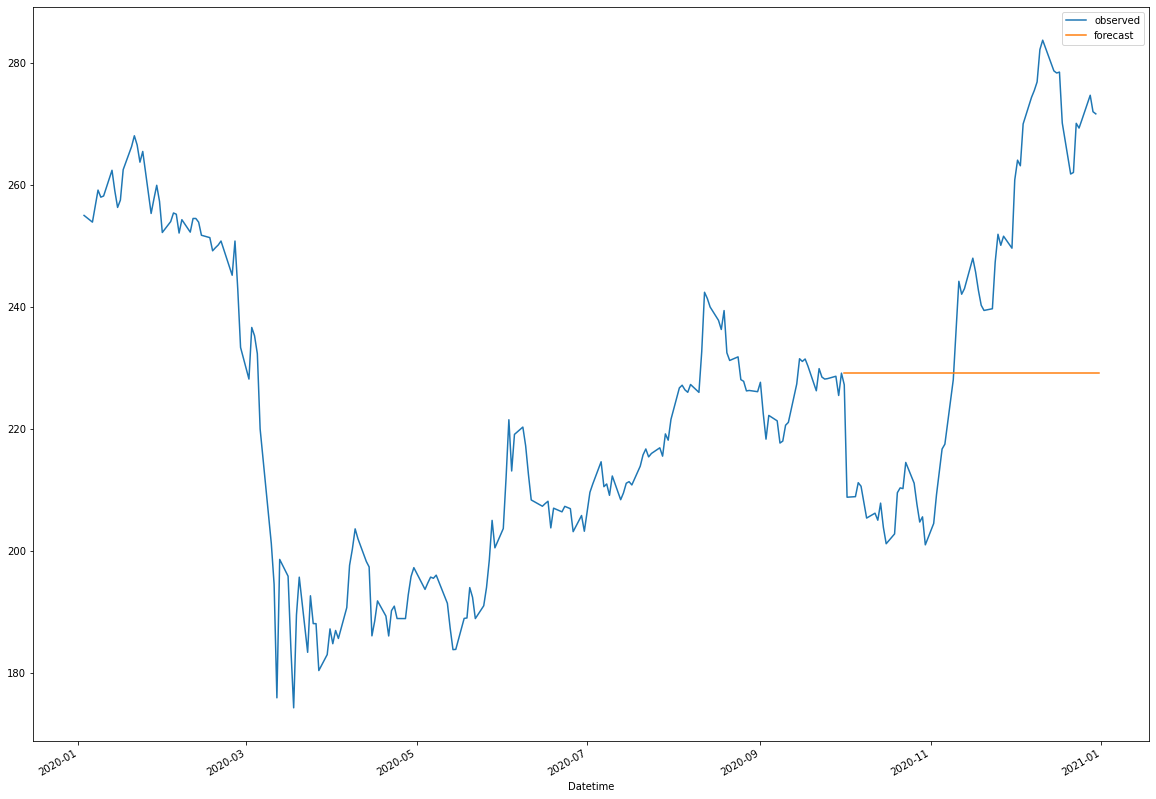

In [165]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 2

In [166]:
predicted = fitted2.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2020-12-31"), dynamic=False, full_results=True)
predicted_ci = fitted2.conf_int()
#predicted.predicted_mean

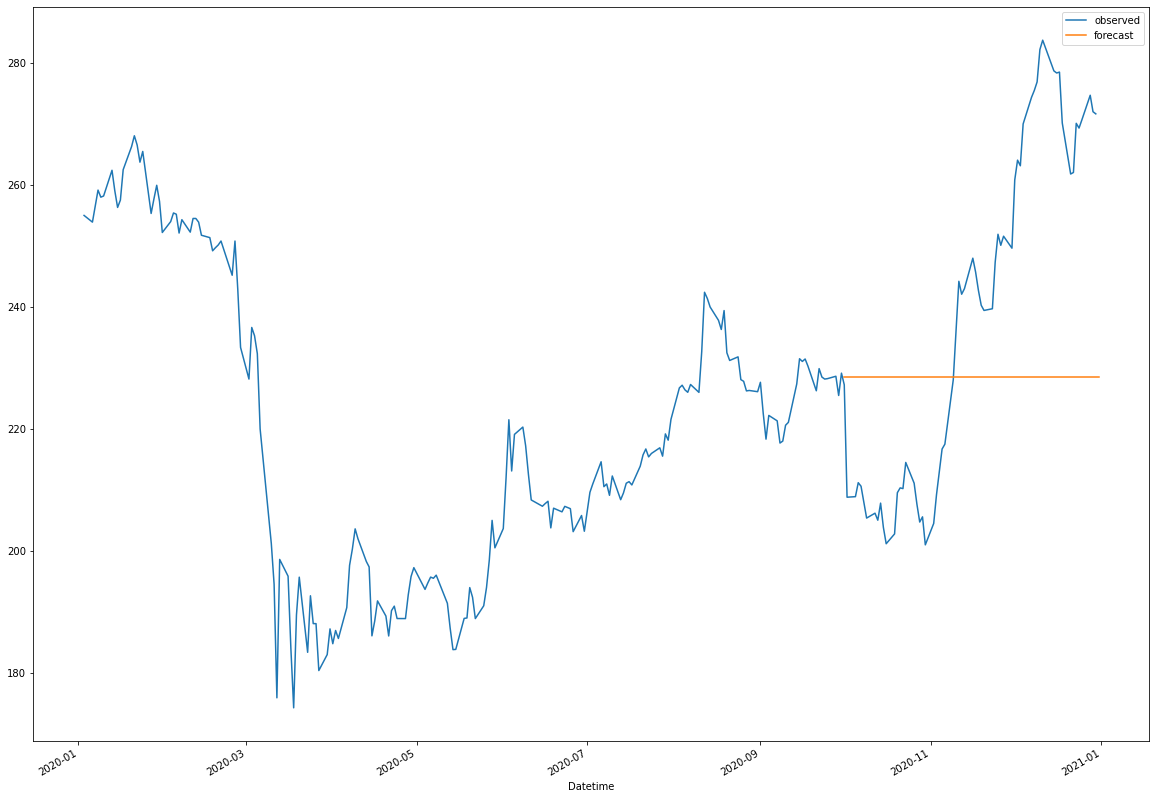

In [167]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 3

In [168]:
predicted = fitted3.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2020-12-31"), dynamic=False, full_results=True)
predicted_ci = fitted3.conf_int()

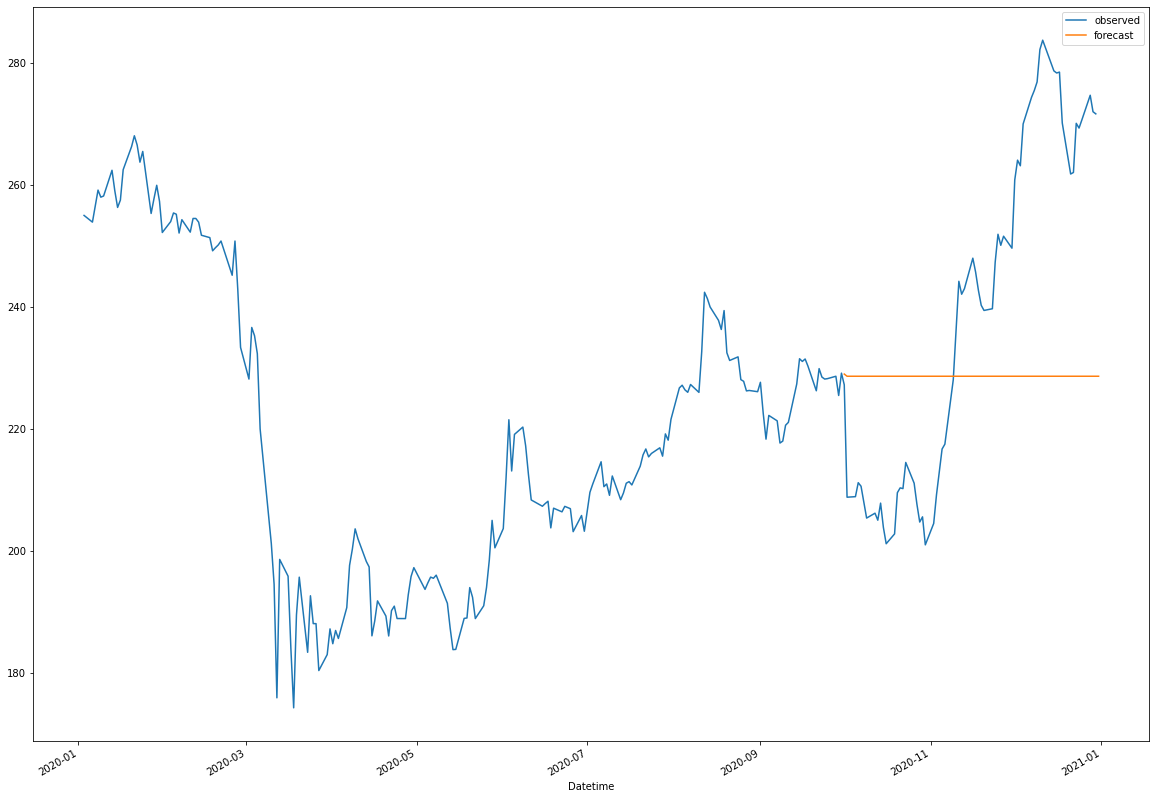

In [169]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 4

In [170]:
predicted = fitted4.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2020-12-31"), dynamic=False, full_results=True)
predicted_ci = fitted4.conf_int()

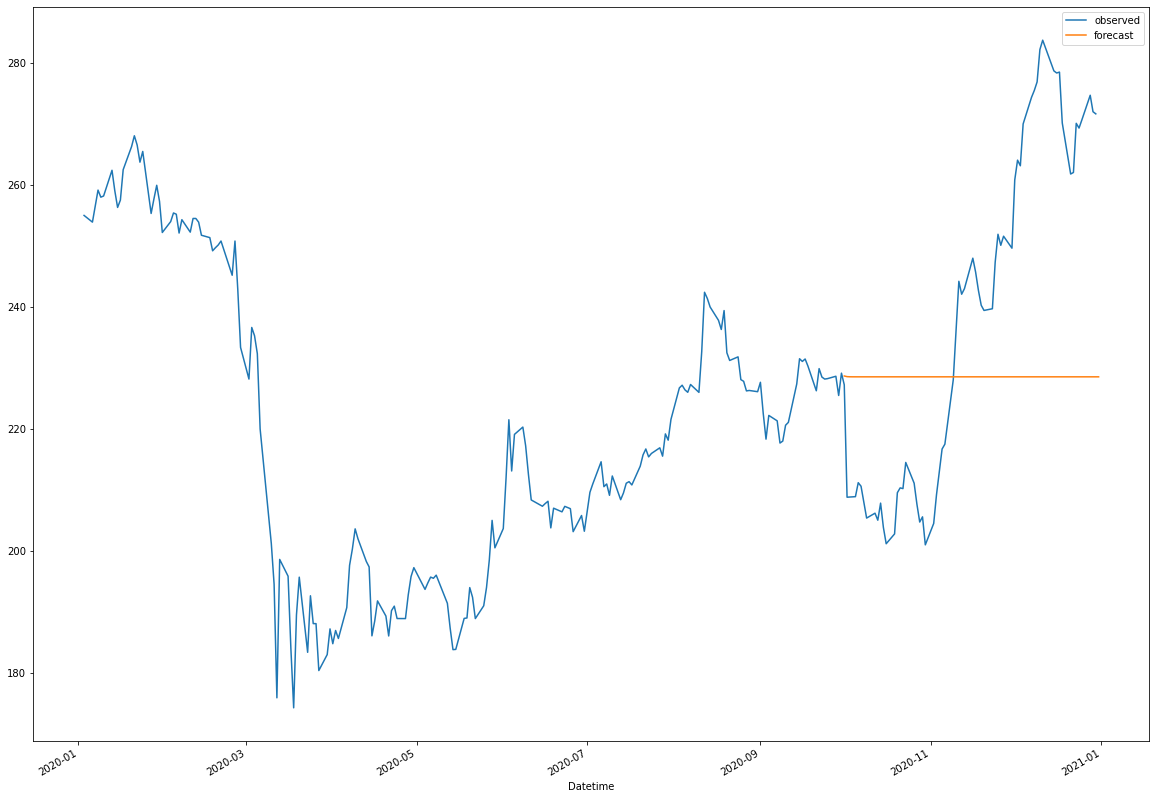

In [171]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

All of the ARIMA models have predictions that quickly (or immediately) converge to a single value.

##### SES (Simple Exponential Smoothing) Model

In [172]:
fit1 = ses_model.fit()
pred1 = fit1.forecast(9)
pred1

array([229.02620215, 229.02620215, 229.02620215, 229.02620215,
       229.02620215, 229.02620215, 229.02620215, 229.02620215,
       229.02620215])

With smoothing_level = 0.2

In [173]:
fit2 = ses_model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(9)
pred2

array([227.93457085, 227.93457085, 227.93457085, 227.93457085,
       227.93457085, 227.93457085, 227.93457085, 227.93457085,
       227.93457085])

With smoothing_level = 0.5

In [174]:
fit3 = ses_model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(9)
pred3

array([228.06394048, 228.06394048, 228.06394048, 228.06394048,
       228.06394048, 228.06394048, 228.06394048, 228.06394048,
       228.06394048])

Each of these models produce a constant value.

##### HES Model

In [178]:
pred_holt = fit_holt.forecast(92)

In [176]:
predictions_holt = pd.Series(pred_holt)
predictions_holt.index = predicted.predicted_mean.index

<AxesSubplot:xlabel='Datetime'>

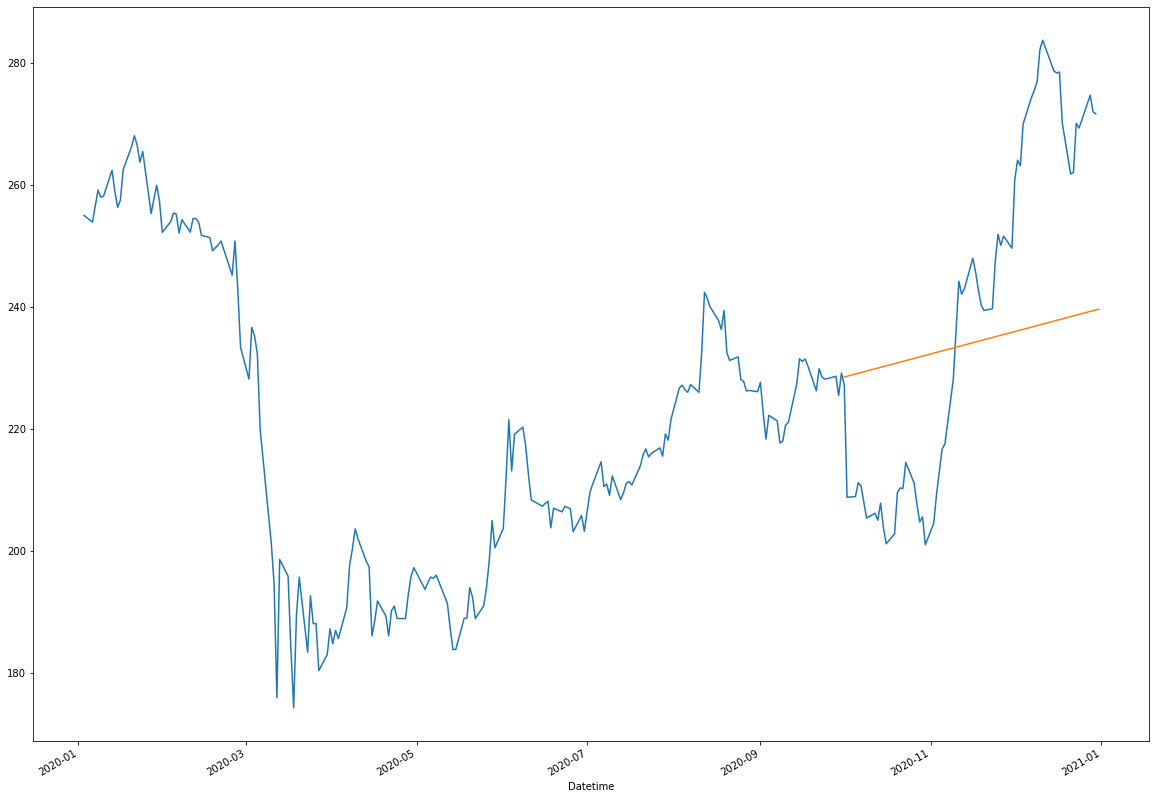

In [177]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predictions_holt.plot(ax=ax, label='forecast')

##### Simple Moving Average Model

### Forecast Future Unknown Data (2021 data)

### Summary